# Imports

In [1]:
%run local_functions.py
from local_functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

from contractions import contractions_dict


plt.style.use("dark_background")


pd.set_option("display.max_columns", 2500)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_colwidth", 500)


plt.style.use("dark_background")

%load_ext lab_black

2023-08-31 14:51:24.073389: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 14:51:24.094104: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 14:51:24.463776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load model

In [2]:
model1 = AutoModelForSequenceClassification.from_pretrained(
    "bert-finetuned-amazon-reviews-multi-train-100k"
)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

trainer1 = Trainer(model=model1, tokenizer=tokenizer)


id2label = load_pickel("label_dicts/id2label.pkl")

# Load test data

In [3]:
df = read_in_and_normalize("datasets/amazon_reviews_multi-test.parquet")
df_test = df[["text", "product_category"]]

In [4]:
df_test

,text,product_category
0,do not waste your time these are awful they are see through the fabric feels like tablecloth and they fit like children s clothing customer service did seem to be nice though but i regret missing my return date for these i would not even donate them because the quality is so poor,apparel
1,one star i bought 4 and none of them worked yes i used new batteries,other
2,totally useless on first use it did not heat up and now it does not work at all,other
3,gold filled earrings you want an honest answer i just returned from ups where i returned the farce of an earring set to amazon it did not look like what i saw on amazon only a baby would be able to wear the size of the earring they were so small the size of a pin head i at first thought amazon had forgotten to enclose them in the bag i did not bother to take them out of the bag and you can have them back will never order another thing from your company a disgrace honest enough for you grandma,jewelry
4,poor container the glue works fine but the container is impossible to work with the cap does not come off without plyers and then will not go back on without a violent abrupt force involving both hands and a solid object desk drawer this happened even though i was careful to not gum up the lid or tapering snout,industrial_supplies
...,...,...
4995,very sleek it is still early but so far the scales seems like a good product it is very modern looking my wife got back from the dr s office and said their scale read 3 pounds lighter than ours so time to shop ours was old so maybe lost some degree of accuracy this inevifit seems to be accurate time will tell we like it hard to give products a 5 when they are still in the testing phase and there is always room for improvement i do not really like to have to use 4 aaa batteries but i will get...,drugstore
4996,face mask a few times now and it works great it also had a pleasant smell will buy it i have used this face mask a few times now and it works great it also had a pleasant smell will buy it again,beauty
4997,five stars great price good quality,home
4998,2016 f150 xlt fits my 2016 f150 xlt great now i dont have to listen to it hitting side to side while driving anymore,automotive


# Evaluate test data - Training -> 2 hrs

In [6]:
ROWS_TO_EVALUATE = 10

CONFIDENCE_THRESHOLD = 0.65  # 0.1 works well for low number of non-responses

TOP_N_PREDS = 5  # number of top predictions to return


# make predictions
df_test["predicted_class"] = df_test["text"][0:ROWS_TO_EVALUATE].apply(
    predict_class, args=(tokenizer, trainer1, id2label, CONFIDENCE_THRESHOLD)
)  # args: text, tokenizer, trainer, id2label, CONFIDENCE_THRESHOLD=0.5

# calculate if prediction is correct
df_test["correct"] = df_test[0:ROWS_TO_EVALUATE].apply(
    lambda row: int(row["product_category"] in row["predicted_class"]), axis=1
)
# calculate score (including penalty for guessing multiple categories) used to help find optimal confidence threshold
df_test["correct_w_discount"] = df_test[0:ROWS_TO_EVALUATE].apply(
    multi_cat_guess_penalty,
    axis=1,
    args=(0.9,),  # muli_cat_guess_penalty (somewhere around 0.85 works well)
)

df_test["correct_w_non_preds"] = df_test[0:ROWS_TO_EVALUATE].apply(
    multi_positive_outcome, axis=1
)

# get top n predictions
df_test["top_n_preds"] = df_test["text"][0:ROWS_TO_EVALUATE].apply(
    n_most_likely_classes, args=(tokenizer, trainer1, id2label, TOP_N_PREDS)
)

print(
    f"Percent of predictions that include correct class: {round((df_test.correct.sum() / ROWS_TO_EVALUATE)*100, 2)}%"
)
print(
    f"Multi_guess discount score: {round((df_test.correct_w_discount.sum() / ROWS_TO_EVALUATE)*100, 2)}%"
)
print(
    f"Multi_positive_outcome discount score: {round((df_test.correct_w_non_preds.sum() / ROWS_TO_EVALUATE)*100, 2)}%"
)

print(
    f"Percent of non-preds: {round((df_test.correct_w_non_preds.sum() - df_test.correct.sum()) / ROWS_TO_EVALUATE*100, 2)}% "
)
print(
    f"Percent of wrong preds: {round((1-(df_test.correct_w_non_preds.sum() / ROWS_TO_EVALUATE))*100,2)}%"
)

Percent of predictions that include correct class: 60.0%
Multi_guess discount score: 60.0%
Multi_positive_outcome discount score: 90.0%
Percent of non-preds: 30.0% 
Percent of wrong preds: 10.0%


/tmp/ipykernel_763056/2075550331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["predicted_class"] = df_test["text"][0:ROWS_TO_EVALUATE].apply(


In [20]:

(df_test.correct_w_non_preds.sum() - df_test.correct.sum()) / ROWS_TO_EVALUATE

0.4234

Confidence Threshold: 0.05
Percent of predictions that include correct class: 76.08%
Multi_guess discount score: 59.33%
Multi_positive_outcome discount score: 76.08%
Percent of non-preds: 0.0% 
Percent of wrong preds: 23.92%
Confidence Threshold: 0.1
Percent of predictions that include correct class: 66.2%
Multi_guess discount score: 58.68%
Multi_positive_outcome discount score: 66.42%
Percent of non-preds: 0.22% 
Percent of wrong preds: 33.58%
Confidence Threshold: 0.15000000000000002
Percent of predictions that include correct class: 60.78%
Multi_guess discount score: 56.37%
Multi_positive_outcome discount score: 64.12%
Percent of non-preds: 3.34% 
Percent of wrong preds: 35.88%
Confidence Threshold: 0.2
Percent of predictions that include correct class: 57.62%
Multi_guess discount score: 54.76%
Multi_positive_outcome discount score: 64.82%
Percent of non-preds: 7.2% 
Percent of wrong preds: 35.18%
Confidence Threshold: 0.25
Percent of predictions that include correct class: 54.5%
Mu

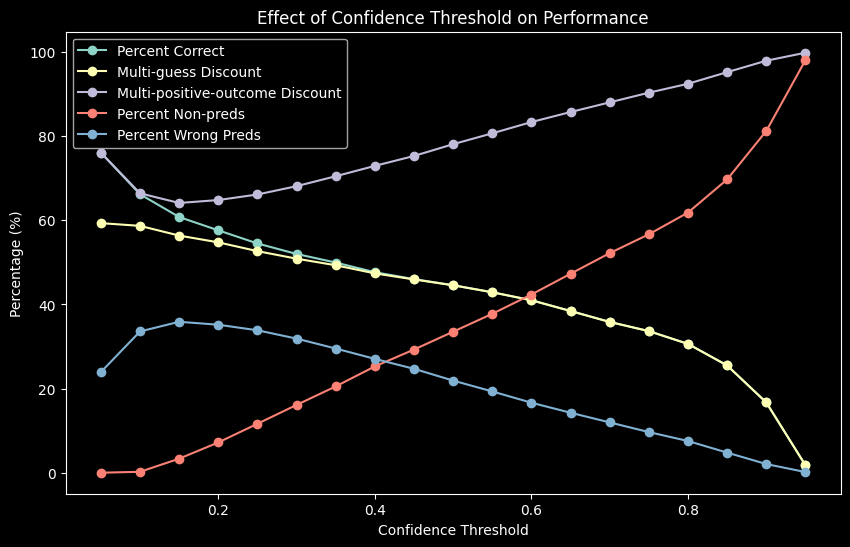

In [16]:
ROWS_TO_EVALUATE = len(df_test)
TOP_N_PREDS = 5

thresholds = []
percent_correct_list = []
percent_correct_discount_list = []
percent_correct_non_preds_list = []
percent_non_preds_list = []
percent_wrong_preds_list = []


for CONFIDENCE_THRESHOLD in np.arange(0.05, 1, 0.05):
    df_test["predicted_class"] = df_test["text"][:ROWS_TO_EVALUATE].apply(
        predict_class, args=(tokenizer, trainer1, id2label, CONFIDENCE_THRESHOLD)
    )

    df_test["correct"] = df_test[:ROWS_TO_EVALUATE].apply(
        lambda row: int(row["product_category"] in row["predicted_class"]), axis=1
    )

    df_test["correct_w_discount"] = df_test[:ROWS_TO_EVALUATE].apply(
        multi_cat_guess_penalty, axis=1, args=(0.9,)
    )

    df_test["correct_w_non_preds"] = df_test[:ROWS_TO_EVALUATE].apply(
        multi_positive_outcome, axis=1
    )

    df_test["top_n_preds"] = df_test["text"][:ROWS_TO_EVALUATE].apply(
        n_most_likely_classes, args=(tokenizer, trainer1, id2label, TOP_N_PREDS)
    )

    percent_correct = (df_test["correct"].sum() / ROWS_TO_EVALUATE) * 100
    percent_correct_discount = (
        df_test["correct_w_discount"].sum() / ROWS_TO_EVALUATE
    ) * 100
    percent_correct_non_preds = (
        df_test["correct_w_non_preds"].sum() / ROWS_TO_EVALUATE
    ) * 100

    percent_non_preds = (
        len(df_test[df_test.predicted_class.str.len() == 0]) / ROWS_TO_EVALUATE
    ) * 100
    percent_wrong_preds = (
        1 - (df_test.correct_w_non_preds.sum() / ROWS_TO_EVALUATE)
    ) * 100

    thresholds.append(CONFIDENCE_THRESHOLD)
    percent_correct_list.append(percent_correct)
    percent_correct_discount_list.append(percent_correct_discount)
    percent_correct_non_preds_list.append(percent_correct_non_preds)
    percent_non_preds_list.append(percent_non_preds)
    percent_wrong_preds_list.append(percent_wrong_preds)

    print(f"Confidence Threshold: {CONFIDENCE_THRESHOLD}")
    print(
        f"Percent of predictions that include correct class: {round(percent_correct, 2)}%"
    )
    print(f"Multi_guess discount score: {round(percent_correct_discount, 2)}%")
    print(
        f"Multi_positive_outcome discount score: {round(percent_correct_non_preds, 2)}%"
    )
    print(f"Percent of non-preds: {round(percent_non_preds, 2)}% ")
    print(f"Percent of wrong preds: {round(percent_wrong_preds, 2)}%")
    print("=" * 75)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, percent_correct_list, marker="o", label="Percent Correct")
plt.plot(
    thresholds, percent_correct_discount_list, marker="o", label="Multi-guess Discount"
)
plt.plot(
    thresholds,
    percent_correct_non_preds_list,
    marker="o",
    label="Multi-positive-outcome",
)

plt.plot(thresholds, percent_non_preds_list, marker="o", label="Percent Non-preds")
plt.plot(thresholds, percent_wrong_preds_list, marker="o", label="Percent Wrong Preds")


plt.xlabel("Confidence Threshold")
plt.ylabel("Percentage (%)")
plt.title("Effect of Confidence Threshold on Performance")
plt.legend()
plt.grid(False)
plt.show()

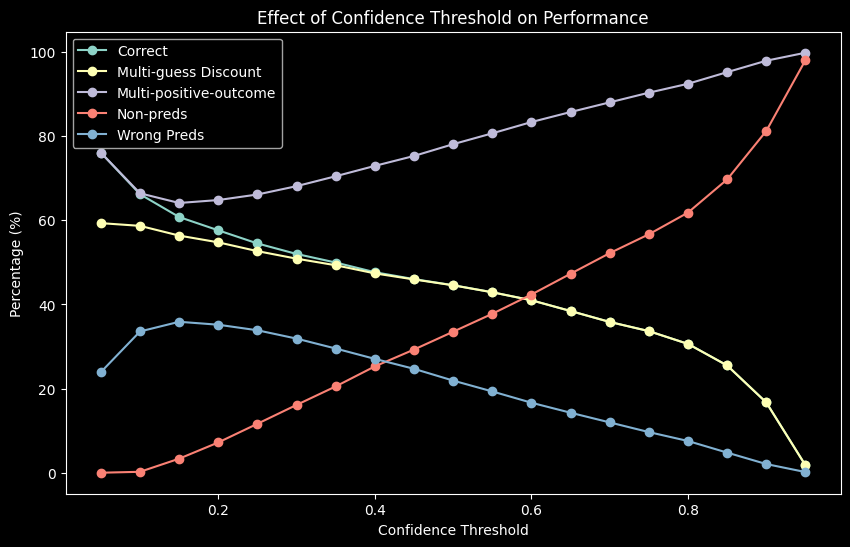

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, percent_correct_list, marker="o", label="Correct")
plt.plot(
    thresholds, percent_correct_discount_list, marker="o", label="Multi-guess Discount"
)
plt.plot(
    thresholds,
    percent_correct_non_preds_list,
    marker="o",
    label="Multi-positive-outcome",
)

plt.plot(thresholds, percent_non_preds_list, marker="o", label="Non-preds")
plt.plot(thresholds, percent_wrong_preds_list, marker="o", label="Wrong Preds")


plt.xlabel("Confidence Threshold")
plt.ylabel("Percentage (%)")
plt.title("Effect of Confidence Threshold on Performance")
plt.legend()
plt.grid(False)
plt.show()

In [17]:
data = {
    "threshold": thresholds,
    "percent_correct": percent_correct_list,
    "percent_correct_discount": percent_correct_discount_list,
    "percent_correct_non_preds": percent_correct_non_preds_list,
    "percent_non_preds": percent_non_preds_list,
    "percent_wrong_preds": percent_wrong_preds_list,
}

In [18]:
results_df = pd.DataFrame(data)
results_df = results_df.round(2)

In [29]:
results_df

,threshold,percent_correct,percent_correct_discount,percent_correct_non_preds,percent_non_preds,percent_wrong_preds
0,0.05,76.08,59.33,76.08,0.00,23.92
1,0.10,66.20,58.68,66.42,0.22,33.58
2,0.15,60.78,56.37,64.12,3.34,35.88
3,0.20,57.62,54.76,64.82,7.20,35.18
4,0.25,54.50,52.67,66.14,11.64,33.86
5,0.30,52.00,50.88,68.12,16.12,31.88
6,0.35,49.96,49.32,70.48,20.52,29.52
7,0.40,47.66,47.38,72.94,25.28,27.06
8,0.45,46.02,45.94,75.30,29.28,24.70
9,0.50,44.58,44.55,78.10,33.52,21.90
